<a href="https://colab.research.google.com/github/RyanChen12035/w266-NLP/blob/main/w266_final_model1_prunning_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydot --quiet
!pip install tensorflow-datasets --quiet
!pip install transformers --quiet

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3e57104d-78d2-a23a-6894-f4a364fddf61)


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()
import sklearn as sk
import os
from nltk.data import find
import matplotlib.pyplot as plt
import re

In [5]:
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

train_examples, train_labels = next(iter(train_data.batch(20000)))
val_examples, val_labels = next(iter(test_data.batch(5000)))
test_examples, test_labels = next(iter(test_data.batch(1000)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMD982L/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMD982L/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMD982L/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [99]:
#allow us to get the hidden layer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased', output_hidden_states=True)
MAX_SEQUENCE_LENGTH = 100

In [100]:
#BERT Tokenization of training and test data
#Embedding size of Bert tokenizer: 768
#Dictionary size of Bert tokenizer: 28,996


train_examples_str = [x.decode('utf-8') for x in train_examples.numpy()]
val_examples_str = [x.decode('utf-8') for x in val_examples.numpy()]
test_examples_str = [x.decode('utf-8') for x in test_examples.numpy()]

#train
bert_train_tokenized = bert_tokenizer(train_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(train_labels)

#val
bert_val_tokenized = bert_tokenizer(val_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_val_inputs = [bert_val_tokenized.input_ids,
                     bert_val_tokenized.token_type_ids,
                     bert_val_tokenized.attention_mask]
bert_val_labels = np.array(val_labels)


#test
bert_test_tokenized = bert_tokenizer(test_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_test_inputs = [bert_test_tokenized.input_ids,
                     bert_test_tokenized.token_type_ids,
                     bert_test_tokenized.attention_mask]
bert_test_labels = np.array(test_labels)

In [101]:
#12 layers of transformer
#A drop out layer + dense layer with 100 hidden layer size on top + final layer with sigmoid as activation function

def create_bert_cls_model(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005,
                          output_cls_tokens=False):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    bert_base_model.trainable = True #True

    #input layers of BERT, shape (batch, max_sequence_length), model will be fit with bert_train_tokenized
    input_ids = Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids')
    token_type_ids = Input(shape=(max_sequence_length,), dtype=tf.int32, name='token_type_ids')
    attention_mask = Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask')

    inputs = [input_ids, token_type_ids, attention_mask]

    #BERT output, last_hidden_state shape (batch, max_sequence_length, embedding dimensions)
    bert_output = bert_base_model(input_ids=input_ids,
                                  token_type_ids=token_type_ids,
                                  attention_mask=attention_mask,
                                  output_hidden_states=output_cls_tokens)

    #Extract the CLS token's output, the embedding representation of first token of every sentence, shape(batch, embedding dimensions)
    cls_token_output = bert_output[0][:, 0, :] # CLS token output from the last layer

    #Add a dropout layer
    x = Dropout(dropout)(cls_token_output)

    #Add a fully connected layer for classification
    x = Dense(hidden_size, activation='relu')(x)

    #Final output layer for classification, assuming it's binary task
    output = Dense(1, activation='sigmoid')(x)


    # CLS output for each layer of transformer
    if output_cls_tokens:
        cls_outputs = [state[:, 0, :] for state in bert_output[2]] # CLS token outputs from all layers
        model_outputs = [output] + cls_outputs

    else:
        model_outputs = output


    #Model complie
    classification_model = Model(inputs=inputs, outputs=model_outputs)
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='binary_crossentropy',
                                 metrics=['accuracy'])

    return classification_model

"""
bert_output[2]: When the output_hidden_states parameter is set to True, this output provides the hidden states from all layers of the BERT model.
It is a list of tensors, where each tensor corresponds to the hidden states of a specific layer.
The shape of each tensor in this list is (batch_size, sequence_length, hidden_size), similar to bert_output[0], but for each individual layer.
"""


'\nbert_output[2]: When the output_hidden_states parameter is set to True, this output provides the hidden states from all layers of the BERT model.\nIt is a list of tensors, where each tensor corresponds to the hidden states of a specific layer.\nThe shape of each tensor in this list is (batch_size, sequence_length, hidden_size), similar to bert_output[0], but for each individual layer.\n'

In [102]:
tf.keras.backend.clear_session()

In [103]:
#bert_model
bert_cls_model_classification = create_bert_cls_model(bert_model, output_cls_tokens=False)
history_cls_bert= bert_cls_model_classification.fit(bert_train_inputs,
                                                    bert_train_labels,
                                                    epochs=2, #2
                                                    batch_size=8, #8
                                                    validation_data=(bert_val_inputs, bert_val_labels))

Epoch 1/2


2500/2500 [==============================] - 530s 197ms/step - loss: 0.4222 - accuracy: 0.8029 - val_loss: 0.3630 - val_accuracy: 0.8322
Epoch 2/2
2500/2500 [==============================] - 485s 194ms/step - loss: 0.2815 - accuracy: 0.8837 - val_loss: 0.3983 - val_accuracy: 0.8396


In [104]:
#Model before zeroing out

bert_cls_model_classification.evaluate(bert_test_inputs, bert_test_labels)

32/32 [==============================] - 10s 213ms/step - loss: 0.3699 - accuracy: 0.8520


[0.36987897753715515, 0.8519999980926514]

In [113]:
import time

start_time = time.time()
prediction = bert_cls_model_classification.predict(bert_test_inputs)
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

32/32 [==============================] - 7s 208ms/step
Elapsed time: 10.29 seconds


Start from here!!

In [106]:
# Example test reviews
"""
1. Identifying Emotional Tone
Sub-Task: Determine the emotional tone of the review (e.g., positive, negative, neutral).
Test Reviews:
    EX1 "The movie's breathtaking scenery and exceptional soundtrack added depth to its rich storytelling." -> Positive Tone
    EX2 "The film was a letdown with its lackluster plot and uninspired performances." -> Negative Tone
2. Analyzing Subjective Statements
Sub-Task: Detect subjective statements or opinions in the review.
Test Reviews:
    EX3 "In my opinion, the film's portrayal of historical events was highly inaccurate." -> Subjective
    EX4 "The movie won three Academy Awards, including Best Picture." -> Objective
3. Evaluating Specific Aspects (Acting, Plot, Cinematography)
Sub-Task: Assess specific aspects of the movie like acting quality, plot development, and cinematography.
Test Reviews:
    EX5 "The acting was superb, with each character bringing depth and emotion to the screen." -> Positive Acting
    EX6 "The plot was predictable and lacked originality, making the movie quite boring." -> Negative Plot
4. Recognizing Extremes in Sentiment
Sub-Task: Identify reviews with extremely positive or negative sentiments.
Test Reviews:
    EX7 "This is possibly the worst movie ever made, with no redeeming qualities whatsoever." -> Extremely Negative
    EX8 "An absolute masterpiece, every moment was captivating and a joy to watch." -> Extremely Positive
5. Detecting Sarcasm or Irony
Sub-Task: Detect sarcasm or irony, which can often invert the apparent sentiment of a statement.
Test Reviews:
    EX9 "Oh great, another predictable rom-com, just what the world needs." -> Sarcasm
    EX10 "I loved how the movie ended abruptly without resolving any plot points." -> Irony
"""

# First reivews is positive tone and the second is negative tone
test_reviews = [
    "In my opinion, the film's portrayal of historical events was highly inaccurate.",
    "The movie won three Academy Awards, including Best Picture.",
    "In my opinion, the film's portrayal of historical events was highly inaccurate.",
    "The movie won three Academy Awards, including Best Picture.",
    "The acting was superb, with each character bringing depth and emotion to the screen.",
    "The plot was predictable and lacked originality, making the movie quite boring.",
    "This is possibly the worst movie ever made, with no redeeming qualities whatsoever.",
    "An absolute masterpiece, every moment was captivating and a joy to watch.",
    "Oh great, another predictable rom-com, just what the world needs.",
    "I loved how the movie ended abruptly without resolving any plot points."
]

# Tokenize the reviews
# 101:[CLS], 102:[SEP]
token_inputs = bert_tokenizer(test_reviews,
                            max_length=MAX_SEQUENCE_LENGTH,
                            truncation=True,
                            padding='max_length',
                            return_tensors='tf')

inputs = [token_inputs.input_ids,
        token_inputs.token_type_ids,
        token_inputs.attention_mask]

print(inputs)

[<tf.Tensor: shape=(10, 100), dtype=int32, numpy=
array([[  101,  1130,  1139,  4893,   117,  1103,  1273,   112,   188,
        14513,  1104,  3009,  1958,  1108,  3023,  1107,  7409, 28106,
          119,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  101,  1109,  2523,  1281,  1210,  2127,  2763,   117,  1259,
         1798, 10041,   119,   102,     0,     0,     0,     0,     0,
           

In [107]:
# Create a model for analysis which includes the hidden states
#bert_model is fine-tuned now, don't have to re-train it. it's an object.
cls_layer_inside_finetunedBERT = create_bert_cls_model(bert_model, output_cls_tokens=True)

#get cls in each layers of transformer inside the fine-tuned BERT
predictions, *cls_hidden_states = cls_layer_inside_finetunedBERT.predict(inputs)
print(cls_hidden_states)

1/1 [==============================] - 3s 3s/step
[array([[ 0.44000068,  0.05448513, -0.2267781 , ..., -0.00599706,
        -0.02674682, -0.08106826],
       [ 0.44000068,  0.05448513, -0.2267781 , ..., -0.00599706,
        -0.02674682, -0.08106826],
       [ 0.44000068,  0.05448513, -0.2267781 , ..., -0.00599706,
        -0.02674682, -0.08106826],
       ...,
       [ 0.44000068,  0.05448513, -0.2267781 , ..., -0.00599706,
        -0.02674682, -0.08106826],
       [ 0.44000068,  0.05448513, -0.2267781 , ..., -0.00599706,
        -0.02674682, -0.08106826],
       [ 0.44000068,  0.05448513, -0.2267781 , ..., -0.00599706,
        -0.02674682, -0.08106826]], dtype=float32), array([[ 0.21972811, -0.04920153, -0.10357504, ..., -0.04456327,
         0.01517739, -0.0576742 ],
       [ 0.2368984 , -0.08724957, -0.09937686, ..., -0.05995465,
         0.01331912, -0.07298006],
       [ 0.21972811, -0.04920153, -0.10357504, ..., -0.04456327,
         0.01517739, -0.0576742 ],
       ...,
       [

In [108]:
import numpy as np
from numpy.linalg import norm

def calculate_similarities(cls_outputs):
    # Number of examples and layers
    num_examples, num_layers = cls_outputs[0].shape[0], len(cls_outputs)

    # Initializing arrays to store the results
    cosine_similarities = np.zeros((num_examples, num_layers))
    dot_products = np.zeros((num_examples, num_layers))

    # Final layer's CLS output
    final_layer_output = cls_outputs[-1]

    # Calculating similarities and dot products
    for i in range(num_layers):
        for j in range(num_examples):
            # Extracting the CLS output for the current layer and example
            current_output = cls_outputs[i][j]

            # Cosine Similarity
            cosine_similarities[j, i] = np.dot(current_output, final_layer_output[j]) / (norm(current_output) * norm(final_layer_output[j]))

            # Dot Product
            dot_products[j, i] = np.dot(current_output, final_layer_output[j])

    return cosine_similarities

cosine_similarities_layer = calculate_similarities(cls_hidden_states)

In [117]:
for var in bert_model.variables:
    print(f"{var.name}: {var.shape}")

tf_bert_model_1/bert/embeddings/word_embeddings/weight:0: (28996, 768)
tf_bert_model_1/bert/embeddings/token_type_embeddings/embeddings:0: (2, 768)
tf_bert_model_1/bert/embeddings/position_embeddings/embeddings:0: (512, 768)
tf_bert_model_1/bert/embeddings/LayerNorm/gamma:0: (768,)
tf_bert_model_1/bert/embeddings/LayerNorm/beta:0: (768,)
tf_bert_model_1/bert/encoder/layer_._0/attention/self/query/kernel:0: (768, 768)
tf_bert_model_1/bert/encoder/layer_._0/attention/self/query/bias:0: (768,)
tf_bert_model_1/bert/encoder/layer_._0/attention/self/key/kernel:0: (768, 768)
tf_bert_model_1/bert/encoder/layer_._0/attention/self/key/bias:0: (768,)
tf_bert_model_1/bert/encoder/layer_._0/attention/self/value/kernel:0: (768, 768)
tf_bert_model_1/bert/encoder/layer_._0/attention/self/value/bias:0: (768,)
tf_bert_model_1/bert/encoder/layer_._0/attention/output/dense/kernel:0: (768, 768)
tf_bert_model_1/bert/encoder/layer_._0/attention/output/dense/bias:0: (768,)
tf_bert_model_1/bert/encoder/layer_.

In [118]:
def extract_ffn_second_dense_weights(bert_model):
    """
    Extracts the kernel weights from the second dense layer of the FFN in each transformer layer of the BERT model.
    """
    ffn_weights = []

    # Loop through each transformer layer and construct the variable name
    for layer_num in range(bert_model.config.num_hidden_layers):
        # Construct the variable name for the second dense layer weights in the current layer
        weight_name = f"tf_bert_model/bert/encoder/layer_._{layer_num}/output/dense/kernel:0"

        # Find and extract the variable
        for var in bert_model.variables:
            if var.name == weight_name:
                weights = var.numpy()  # Convert to numpy array
                ffn_weights.append(weights)
                break  # Move to the next layer once the weights are found

    return ffn_weights

ffn_weights = extract_ffn_second_dense_weights(bert_model)

In [120]:
# input of EX1. cls_hidden_states (layer, example, embedding dimensions)
cls_token_output = cls_hidden_states[12][0][:]

def compute_cosine_similarities(cls_token_output, ffn_weights):
    # Normalize the CLS token output
    cls_norm = np.linalg.norm(cls_token_output)
    cls_token_normalized = cls_token_output / cls_norm

    cosine_similarities = []

    for layer_weights in ffn_weights:
        # Transpose the weights to align dimensions with CLS token output
        # layer_weights shape is (3072, 768), after transpose it will be (768, 3072)
        transposed_weights = layer_weights.T

        # Normalize the neuron weights
        neuron_norms = np.linalg.norm(transposed_weights, axis=0)
        normalized_neurons = transposed_weights / neuron_norms

        # Compute the dot product
        dot_product = np.dot(cls_token_normalized, normalized_neurons)

        cosine_similarities.append(dot_product)

    return cosine_similarities

#'cls_token_output' is the CLS token output of shape (768,)
# And 'ffn_weights' is a list of arrays, each of shape (3072, 768)
cosine_similarities_neurons = compute_cosine_similarities(cls_token_output, ffn_weights)

print(cosine_similarities_neurons)

[array([-0.01494084,  0.05668034, -0.02982756, ...,  0.05662605,
        0.05466294, -0.03409785], dtype=float32), array([-0.06058973,  0.04392249, -0.02867114, ...,  0.10180727,
        0.00615106,  0.04328274], dtype=float32), array([ 0.06604717, -0.10433397, -0.03235903, ..., -0.00120658,
        0.01229993, -0.01973242], dtype=float32), array([ 0.05901582,  0.06623787,  0.0797801 , ..., -0.0162824 ,
        0.06258909, -0.02806106], dtype=float32), array([-0.09450251,  0.05326971,  0.05664657, ..., -0.00316199,
        0.02760399,  0.01710795], dtype=float32), array([ 0.00425418,  0.06418082, -0.00065368, ..., -0.03209441,
       -0.01121631,  0.0125576 ], dtype=float32), array([-0.03889253, -0.02022931, -0.03501442, ..., -0.00178085,
        0.03813599,  0.06337235], dtype=float32), array([ 0.03226402, -0.02143049, -0.02747076, ...,  0.00915863,
        0.01609485, -0.01158239], dtype=float32), array([ 0.06940168,  0.03175548, -0.01064995, ...,  0.09889178,
        0.02891949,  0.

In [163]:
#input 5
#output: masked_neurons_list
#input: cosine_similarities_neurons, cosine_similarities_layer, alpha
#Think over it in odd layers and rethink it in even layers. Neruons in odd layer are more concentrated with information (high similarity) so we can prune off
#more in odd layers.
# The information gradually concetrated after layers
#cosine similarity can be negative, cos_sin = 0 irrelavent, -1~0, 0~1


def pruning_strategy(cosine_similarities_neurons, cosine_similarities_layer, alpha, beta):
    masked_neurons_list = [[] for i in range(12)]

    for layer in range(12):
        if layer in range(3):
            for num, simi in enumerate(cosine_similarities_neurons[layer]):
                if (cosine_similarities_layer[1][layer]*alpha) > simi > -(cosine_similarities_layer[1][layer]*alpha):
                    masked_neurons_list[layer].append(num)
            print(f"Threshold of layer {layer} are between {cosine_similarities_layer[1][layer]*alpha} and {-(cosine_similarities_layer[1][layer]*alpha)}")

        elif layer in [3, 5, 7, 9]: #lower the bar
            for num, simi in enumerate(cosine_similarities_neurons[layer]):
                if (beta*layer + cosine_similarities_layer[1][layer]*alpha) > simi > -(beta*layer + cosine_similarities_layer[1][layer]*alpha):
                    masked_neurons_list[layer].append(num)
            print(f"Threshold of layer {layer} are between {beta*layer + cosine_similarities_layer[1][layer]*alpha} and {-(beta*layer + cosine_similarities_layer[1][layer]*alpha)}")

        elif layer in [4, 6, 8, 10]: #raise the bar
            for num, simi in enumerate(cosine_similarities_neurons[layer]):
                if (3*beta*layer + cosine_similarities_layer[1][layer]*alpha) > simi > -(3*beta*layer + cosine_similarities_layer[1][layer]*alpha):
                    masked_neurons_list[layer].append(num)
            print(f"Threshold of layer {layer} are between {3*beta*layer + cosine_similarities_layer[1][layer]*alpha} and {-(3*beta*layer + cosine_similarities_layer[1][layer]*alpha)}")

        else: #layer 11 -> very tight
            for num, simi in enumerate(cosine_similarities_neurons[layer]):
                if simi < 3*cosine_similarities_layer[5][layer]*alpha:
                    masked_neurons_list[layer].append(num)
            print(f"Threshold of layer {layer} is {cosine_similarities_layer[1][layer]*alpha}")
        print(f"number of neruons being masked in layer {layer}: {len(masked_neurons_list[layer])}")

    return masked_neurons_list

masked_neurons_list = pruning_strategy(cosine_similarities_neurons, cosine_similarities_layer, alpha=0.08, beta=0.005)
print(masked_neurons_list)

Threshold of layer 0 are between 0.01678290367126465 and -0.01678290367126465
number of neruons being masked in layer 0: 951
Threshold of layer 1 are between 0.02311490535736084 and -0.02311490535736084
number of neruons being masked in layer 1: 1180
Threshold of layer 2 are between 0.024289703369140627 and -0.024289703369140627
number of neruons being masked in layer 2: 1150
Threshold of layer 3 are between 0.03834619522094727 and -0.03834619522094727
number of neruons being masked in layer 3: 1733
Threshold of layer 4 are between 0.08303236007690429 and -0.08303236007690429
number of neruons being masked in layer 4: 2808
Threshold of layer 5 are between 0.05365514516830444 and -0.05365514516830444
number of neruons being masked in layer 5: 2214
Threshold of layer 6 are between 0.12053423166275024 and -0.12053423166275024
number of neruons being masked in layer 6: 3011
Threshold of layer 7 are between 0.06797332763671876 and -0.06797332763671876
number of neruons being masked in layer

In [164]:
#zero out the weights except presrved neurons.
preserved_neuron_list = [[75, 239, 283, 307, 489, 537, 2018, 2625, 2670, 2773, 765, 1669],
                       [11, 113, 376, 524, 672, 1685, 1766, 1838],
                       [57, 789, 923,1316 ,2719, 2801, 3062],
                       [323, 693, 1469, 1795, 2233],
                       [102, 170, 642, 915, 2116, 2548],
                       [55],
                       [1443, 1506, 1712],
                       [],
                       [763],
                       [2528],
                       [],
                       [1023]]

num_neurons = 3072
masks = []


for i, masked_neurons in enumerate(masked_neurons_list):
    mask = np.ones(num_neurons)
    if masked_neurons not in preserved_neuron_list[i]:
      mask[masked_neurons] = 0
      masks.append(mask)

In [165]:
#zero out -> quantization + sparse matrix pruning
# Assuming bert_model is your pre-trained BERT model
#tf_bert_model/bert/encoder/layer_._0/output/dense/kernel

for var in bert_model.variables:
    if 'output/dense/kernel' in var.name and 'attention' not in var.name:
        # Extract layer number from variable name
        layer_num = int(var.name.split('/')[3].split('_')[2])

        # Get the current weights
        weights = var.numpy()

        # Apply the mask #(3072,)
        mask = masks[layer_num]
        weights *= mask.reshape(-1, 1)  # Reshape mask and apply to weights

        # Assign the modified weights back to the variable
        var.assign(weights)


In [166]:
#bert_model has been zeroed out.
bert_cls_model_classification.evaluate(bert_test_inputs, bert_test_labels)

#            accuracy process time (1000 inputs)  0.860, 0.843, 0.843, 0.777,0.794, 0.688, 0.657   13.71, 10.3, 10.22, 10.33, 10.29, 7.35, 10.33
# 0%        --  0.860 13.71
#alpha 0.01, beta 0.001  -- 0.843 10.3 (0.862, 13.71) (3times only in layer 11 )
#alpha 0.025,beta 0.001 -- 0.843 10.22  (0.862, 13.71) (3times only in layer 11 )
#alpha 0.05, beta 0.001 -- 0.777 10.33  (0.862, 13.71) (3times only in layer 11 )

#alpha 0.05, beta 0.005 -- 0.794 10.29  (0.862, 13.71) (3times only in layer 11 )
#alpha 0.05, beta 0.01 -- 0.688 7.35/10.42  (0.862, 13.71) (3times only in layer 11 )
#alpha 0.05, beta 0.02 -- 0.657 10.33/10.42  (0.862, 13.71) (3times only in layer 11 )


# 0%        --  0.852, 10.29        0.852, 0.857, 0.851, 0.831, 0.807, 0.816, 0.780       10.29, 10.45, 10.32, 10.42, 7.29, 7.2, 10.3
#alpha 0.01, beta 0.001 0.857, 10.45 --(0.852, 10.29) (3times only in layer 11 )
#alpha 0.01, beta 0.002 0.851 10.32 --  (0.852, 10.29) (3times only in layer 11 )
#alpha 0.01, beta 0.005 0.831 10.42 --  (0.852, 10.29) (3times only in layer 11 )

#alpha 0.02, beta 0.005 0.807 7.29/7.1 (0.852, 10.29) (3times only in layer 11)
#alpha 0.05,beta 0.005 -- 0.816 7.2  (0.852, 10.29) (3times only in layer 11 )
#alpha 0.08, beta 0.005 -- 0.78 10.3  (0.852, 10.29) (3times only in layer 11 )

#beta over alpha, increase by layers
# 7~10 fluation

#Impending for further verifying

32/32 [==============================] - 7s 214ms/step - loss: 0.5020 - accuracy: 0.7800


[0.5020490884780884, 0.7799999713897705]

In [167]:
import time

start_time = time.time()
prediction = bert_cls_model_classification.predict(bert_test_inputs)
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

32/32 [==============================] - 7s 220ms/step
Elapsed time: 10.32 seconds


In [ ]:
"""
#alpha 0.01, beta 0.001  --  (0.862, 13.71) (3times only in layer 11 )
Threshold of layer 0 are between 0.0038625508546829223 and -0.0038625508546829223
number of neruons being masked in layer 0: 207
Threshold of layer 1 are between 0.004827066957950592 and -0.004827066957950592
number of neruons being masked in layer 1: 233
Threshold of layer 2 are between 0.004570650458335877 and -0.004570650458335877
number of neruons being masked in layer 2: 195
Threshold of layer 3 are between 0.007254678189754486 and -0.007254678189754486
number of neruons being masked in layer 3: 347
Threshold of layer 4 are between 0.016232426881790163 and -0.016232426881790163
number of neruons being masked in layer 4: 732
Threshold of layer 5 are between 0.009341769516468049 and -0.009341769516468049
number of neruons being masked in layer 5: 429
Threshold of layer 6 are between 0.02249687480926514 and -0.02249687480926514
number of neruons being masked in layer 6: 932
Threshold of layer 7 are between 0.011727830588817597 and -0.011727830588817597
number of neruons being masked in layer 7: 579
Threshold of layer 8 are between 0.028978512823581697 and -0.028978512823581697
number of neruons being masked in layer 8: 1453
Threshold of layer 9 are between 0.014823191404342653 and -0.014823191404342653
number of neruons being masked in layer 9: 787
Threshold of layer 10 are between 0.03750113844871521 and -0.03750113844871521
number of neruons being masked in layer 10: 1979
Threshold of layer 11 is 0.009035356044769287
number of neruons being masked in layer 11: 2594

#alpha 0.025,beta 0.001 --   (0.862, 13.71) (3times only in layer 11 )
Threshold of layer 0 are between 0.009656377136707306 and -0.009656377136707306
number of neruons being masked in layer 0: 512
Threshold of layer 1 are between 0.012067667394876481 and -0.012067667394876481
number of neruons being masked in layer 1: 551
Threshold of layer 2 are between 0.011426626145839692 and -0.011426626145839692
number of neruons being masked in layer 2: 478
Threshold of layer 3 are between 0.013636695474386215 and -0.013636695474386215
number of neruons being masked in layer 3: 622
Threshold of layer 4 are between 0.022581067204475405 and -0.022581067204475405
number of neruons being masked in layer 4: 991
Threshold of layer 5 are between 0.015854423791170122 and -0.015854423791170122
number of neruons being masked in layer 5: 706
Threshold of layer 6 are between 0.029242187023162843 and -0.029242187023162843
number of neruons being masked in layer 6: 1173
Threshold of layer 7 are between 0.018819576472043992 and -0.018819576472043992
number of neruons being masked in layer 7: 917
Threshold of layer 8 are between 0.03644628205895424 and -0.03644628205895424
number of neruons being masked in layer 8: 1736
Threshold of layer 9 are between 0.023557978510856628 and -0.023557978510856628
number of neruons being masked in layer 9: 1204
Threshold of layer 10 are between 0.04875284612178803 and -0.04875284612178803
number of neruons being masked in layer 10: 2359
Threshold of layer 11 is 0.02258839011192322
number of neruons being masked in layer 11: 2946


#alpha 0.05, beta 0.001 --    (0.862, 13.71) (3times only in layer 11 )
Threshold of layer 0 are between 0.019312754273414612 and -0.019312754273414612
number of neruons being masked in layer 0: 1010
Threshold of layer 1 are between 0.024135334789752962 and -0.024135334789752962
number of neruons being masked in layer 1: 1056
Threshold of layer 2 are between 0.022853252291679383 and -0.022853252291679383
number of neruons being masked in layer 2: 962
Threshold of layer 3 are between 0.02427339094877243 and -0.02427339094877243
number of neruons being masked in layer 3: 1055
Threshold of layer 4 are between 0.03316213440895081 and -0.03316213440895081
number of neruons being masked in layer 4: 1458
Threshold of layer 5 are between 0.026708847582340243 and -0.026708847582340243
number of neruons being masked in layer 5: 1105
Threshold of layer 6 are between 0.04048437404632568 and -0.04048437404632568
number of neruons being masked in layer 6: 1572
Threshold of layer 7 are between 0.030639152944087984 and -0.030639152944087984
number of neruons being masked in layer 7: 1416
Threshold of layer 8 are between 0.04889256411790848 and -0.04889256411790848
number of neruons being masked in layer 8: 2174
Threshold of layer 9 are between 0.03811595702171326 and -0.03811595702171326
number of neruons being masked in layer 9: 1840
Threshold of layer 10 are between 0.06750569224357605 and -0.06750569224357605
number of neruons being masked in layer 10: 2744
Threshold of layer 11 is 0.04517678022384644
number of neruons being masked in layer 11: 3055

#alpha 0.05, beta 0.005 --   (0.862, 13.71) (3times only in layer 11 )
account_circle
Threshold of layer 0 are between 0.019312754273414612 and -0.019312754273414612
number of neruons being masked in layer 0: 1010
Threshold of layer 1 are between 0.024135334789752962 and -0.024135334789752962
number of neruons being masked in layer 1: 1056
Threshold of layer 2 are between 0.022853252291679383 and -0.022853252291679383
number of neruons being masked in layer 2: 962
Threshold of layer 3 are between 0.03627339094877243 and -0.03627339094877243
number of neruons being masked in layer 3: 1487
Threshold of layer 4 are between 0.0811621344089508 and -0.0811621344089508
number of neruons being masked in layer 4: 2621
Threshold of layer 5 are between 0.04670884758234024 and -0.04670884758234024
number of neruons being masked in layer 5: 1793
Threshold of layer 6 are between 0.11248437404632568 and -0.11248437404632568
number of neruons being masked in layer 6: 2871
Threshold of layer 7 are between 0.05863915294408799 and -0.05863915294408799
number of neruons being masked in layer 7: 2326
Threshold of layer 8 are between 0.14489256411790846 and -0.14489256411790846
number of neruons being masked in layer 8: 3033
Threshold of layer 9 are between 0.07411595702171325 and -0.07411595702171325
number of neruons being masked in layer 9: 2737
Threshold of layer 10 are between 0.18750569224357605 and -0.18750569224357605
number of neruons being masked in layer 10: 3064
Threshold of layer 11 is 0.04517678022384644
number of neruons being masked in layer 11: 3055

#alpha 0.05, beta 0.01  --   (0.862, 13.71) (3times only in layer 11 )
Threshold of layer 0 are between 0.019312754273414612 and -0.019312754273414612
number of neruons being masked in layer 0: 1010
Threshold of layer 1 are between 0.024135334789752962 and -0.024135334789752962
number of neruons being masked in layer 1: 1056
Threshold of layer 2 are between 0.022853252291679383 and -0.022853252291679383
number of neruons being masked in layer 2: 962
Threshold of layer 3 are between 0.05127339094877243 and -0.05127339094877243
number of neruons being masked in layer 3: 1972
Threshold of layer 4 are between 0.1411621344089508 and -0.1411621344089508
number of neruons being masked in layer 4: 2980
Threshold of layer 5 are between 0.07170884758234025 and -0.07170884758234025
number of neruons being masked in layer 5: 2373
Threshold of layer 6 are between 0.2024843740463257 and -0.2024843740463257
number of neruons being masked in layer 6: 3054
Threshold of layer 7 are between 0.09363915294408799 and -0.09363915294408799
number of neruons being masked in layer 7: 2802
Threshold of layer 8 are between 0.26489256411790846 and -0.26489256411790846
number of neruons being masked in layer 8: 3069
Threshold of layer 9 are between 0.11911595702171325 and -0.11911595702171325
number of neruons being masked in layer 9: 3003
Threshold of layer 10 are between 0.33750569224357607 and -0.33750569224357607
number of neruons being masked in layer 10: 3072
Threshold of layer 11 is 0.04517678022384644
number of neruons being masked in layer 11: 3055



#alpha 0.05, beta 0.02 --   (0.862, 13.71) (3times only in layer 11 )
Threshold of layer 0 are between 0.019312754273414612 and -0.019312754273414612
number of neruons being masked in layer 0: 1010
Threshold of layer 1 are between 0.024135334789752962 and -0.024135334789752962
number of neruons being masked in layer 1: 1056
Threshold of layer 2 are between 0.022853252291679383 and -0.022853252291679383
number of neruons being masked in layer 2: 962
Threshold of layer 3 are between 0.08127339094877242 and -0.08127339094877242
number of neruons being masked in layer 3: 2578
Threshold of layer 4 are between 0.2611621344089508 and -0.2611621344089508
number of neruons being masked in layer 4: 3056
Threshold of layer 5 are between 0.12170884758234024 and -0.12170884758234024
number of neruons being masked in layer 5: 2897
Threshold of layer 6 are between 0.3824843740463257 and -0.3824843740463257
number of neruons being masked in layer 6: 3072
Threshold of layer 7 are between 0.16363915294408798 and -0.16363915294408798
number of neruons being masked in layer 7: 3038
Threshold of layer 8 are between 0.5048925641179085 and -0.5048925641179085
number of neruons being masked in layer 8: 3072
Threshold of layer 9 are between 0.20911595702171326 and -0.20911595702171326
number of neruons being masked in layer 9: 3063
Threshold of layer 10 are between 0.637505692243576 and -0.637505692243576
number of neruons being masked in layer 10: 3072
Threshold of layer 11 is 0.04517678022384644
number of neruons being masked in layer 11: 3055

#alpha 0.01, beta 0.001  --(0.862, 13.71) (3times only in layer 11 )
Threshold of layer 0 are between 0.0020978629589080812 and -0.0020978629589080812
number of neruons being masked in layer 0: 124
Threshold of layer 1 are between 0.002889363169670105 and -0.002889363169670105
number of neruons being masked in layer 1: 151
Threshold of layer 2 are between 0.0030362129211425784 and -0.0030362129211425784
number of neruons being masked in layer 2: 142
Threshold of layer 3 are between 0.0059182744026184085 and -0.0059182744026184085
number of neruons being masked in layer 3: 281
Threshold of layer 4 are between 0.014879045009613037 and -0.014879045009613037
number of neruons being masked in layer 4: 803
Threshold of layer 5 are between 0.008581893146038055 and -0.008581893146038055
number of neruons being masked in layer 5: 444
Threshold of layer 6 are between 0.021816778957843782 and -0.021816778957843782
number of neruons being masked in layer 6: 1124
Threshold of layer 7 are between 0.011121665954589844 and -0.011121665954589844
number of neruons being masked in layer 7: 604
Threshold of layer 8 are between 0.02808003181219101 and -0.02808003181219101
number of neruons being masked in layer 8: 1538
Threshold of layer 9 are between 0.013931202828884125 and -0.013931202828884125
number of neruons being masked in layer 9: 755
Threshold of layer 10 are between 0.03692654490470886 and -0.03692654490470886
number of neruons being masked in layer 10: 2017
Threshold of layer 11 is 0.008632457256317139
number of neruons being masked in layer 11: 2646

#alpha 0.01, beta 0.002 --  (0.862, 13.71) (3times only in layer 11 )
Threshold of layer 0 are between 0.0020978629589080812 and -0.0020978629589080812
number of neruons being masked in layer 0: 124
Threshold of layer 1 are between 0.002889363169670105 and -0.002889363169670105
number of neruons being masked in layer 1: 151
Threshold of layer 2 are between 0.0030362129211425784 and -0.0030362129211425784
number of neruons being masked in layer 2: 142
Threshold of layer 3 are between 0.008918274402618408 and -0.008918274402618408
number of neruons being masked in layer 3: 432
Threshold of layer 4 are between 0.026879045009613037 and -0.026879045009613037
number of neruons being masked in layer 4: 1378
Threshold of layer 5 are between 0.013581893146038056 and -0.013581893146038056
number of neruons being masked in layer 5: 646
Threshold of layer 6 are between 0.03981677895784379 and -0.03981677895784379
number of neruons being masked in layer 6: 1876
Threshold of layer 7 are between 0.018121665954589843 and -0.018121665954589843
number of neruons being masked in layer 7: 968
Threshold of layer 8 are between 0.05208003181219101 and -0.05208003181219101
number of neruons being masked in layer 8: 2436
Threshold of layer 9 are between 0.022931202828884126 and -0.022931202828884126
number of neruons being masked in layer 9: 1245
Threshold of layer 10 are between 0.06692654490470885 and -0.06692654490470885
number of neruons being masked in layer 10: 2748
Threshold of layer 11 is 0.008632457256317139
number of neruons being masked in layer 11: 2646

#alpha 0.01, beta 0.005 --  (0.862, 13.71) (3times only in layer 11 )
Threshold of layer 0 are between 0.0020978629589080812 and -0.0020978629589080812
number of neruons being masked in layer 0: 124
Threshold of layer 1 are between 0.002889363169670105 and -0.002889363169670105
number of neruons being masked in layer 1: 151
Threshold of layer 2 are between 0.0030362129211425784 and -0.0030362129211425784
number of neruons being masked in layer 2: 142
Threshold of layer 3 are between 0.01791827440261841 and -0.01791827440261841
number of neruons being masked in layer 3: 861
Threshold of layer 4 are between 0.06287904500961304 and -0.06287904500961304
number of neruons being masked in layer 4: 2509
Threshold of layer 5 are between 0.028581893146038057 and -0.028581893146038057
number of neruons being masked in layer 5: 1360
Threshold of layer 6 are between 0.09381677895784378 and -0.09381677895784378
number of neruons being masked in layer 6: 2879
Threshold of layer 7 are between 0.039121665954589845 and -0.039121665954589845
number of neruons being masked in layer 7: 1904
Threshold of layer 8 are between 0.124080031812191 and -0.124080031812191
number of neruons being masked in layer 8: 3046
Threshold of layer 9 are between 0.04993120282888412 and -0.04993120282888412
number of neruons being masked in layer 9: 2350
Threshold of layer 10 are between 0.15692654490470886 and -0.15692654490470886
number of neruons being masked in layer 10: 3064
Threshold of layer 11 is 0.008632457256317139
number of neruons being masked in layer 11: 2646

#alpha 0.02,beta 0.005 --  (0.862, 13.71) (3times only in layer 11 )

Threshold of layer 0 are between 0.0041957259178161625 and -0.0041957259178161625
number of neruons being masked in layer 0: 223
Threshold of layer 1 are between 0.00577872633934021 and -0.00577872633934021
number of neruons being masked in layer 1: 298
Threshold of layer 2 are between 0.006072425842285157 and -0.006072425842285157
number of neruons being masked in layer 2: 298
Threshold of layer 3 are between 0.020836548805236818 and -0.020836548805236818
number of neruons being masked in layer 3: 987
Threshold of layer 4 are between 0.06575809001922607 and -0.06575809001922607
number of neruons being masked in layer 4: 2558
Threshold of layer 5 are between 0.03216378629207611 and -0.03216378629207611
number of neruons being masked in layer 5: 1503
Threshold of layer 6 are between 0.09763355791568756 and -0.09763355791568756
number of neruons being masked in layer 6: 2904
Threshold of layer 7 are between 0.04324333190917969 and -0.04324333190917969
number of neruons being masked in layer 7: 2061
Threshold of layer 8 are between 0.128160063624382 and -0.128160063624382
number of neruons being masked in layer 8: 3049
Threshold of layer 9 are between 0.054862405657768246 and -0.054862405657768246
number of neruons being masked in layer 9: 2478
Threshold of layer 10 are between 0.1638530898094177 and -0.1638530898094177
number of neruons being masked in layer 10: 3064
Threshold of layer 11 is 0.017264914512634278
number of neruons being masked in layer 11: 2921

#alpha 0.05, beta 0.005 --  (0.862, 13.71) (3times only in layer 11 )
Threshold of layer 0 are between 0.010489314794540405 and -0.010489314794540405
number of neruons being masked in layer 0: 605
Threshold of layer 1 are between 0.014446815848350525 and -0.014446815848350525
number of neruons being masked in layer 1: 737
Threshold of layer 2 are between 0.01518106460571289 and -0.01518106460571289
number of neruons being masked in layer 2: 728
Threshold of layer 3 are between 0.02959137201309204 and -0.02959137201309204
number of neruons being masked in layer 3: 1384
Threshold of layer 4 are between 0.07439522504806519 and -0.07439522504806519
number of neruons being masked in layer 4: 2699
Threshold of layer 5 are between 0.04290946573019028 and -0.04290946573019028
number of neruons being masked in layer 5: 1880
Threshold of layer 6 are between 0.1090838947892189 and -0.1090838947892189
number of neruons being masked in layer 6: 2972
Threshold of layer 7 are between 0.05560832977294922 and -0.05560832977294922
number of neruons being masked in layer 7: 2378
Threshold of layer 8 are between 0.14040015906095504 and -0.14040015906095504
number of neruons being masked in layer 8: 3058
Threshold of layer 9 are between 0.06965601414442063 and -0.06965601414442063
number of neruons being masked in layer 9: 2760
Threshold of layer 10 are between 0.18463272452354432 and -0.18463272452354432
number of neruons being masked in layer 10: 3065
Threshold of layer 11 is 0.04316228628158569
number of neruons being masked in layer 11: 3066

#alpha 0.08, beta 0.05 --   (0.862, 13.71) (3times only in layer 11 )
Threshold of layer 0 are between 0.01678290367126465 and -0.01678290367126465
number of neruons being masked in layer 0: 951
Threshold of layer 1 are between 0.02311490535736084 and -0.02311490535736084
number of neruons being masked in layer 1: 1180
Threshold of layer 2 are between 0.024289703369140627 and -0.024289703369140627
number of neruons being masked in layer 2: 1150
Threshold of layer 3 are between 0.03834619522094727 and -0.03834619522094727
number of neruons being masked in layer 3: 1733
Threshold of layer 4 are between 0.08303236007690429 and -0.08303236007690429
number of neruons being masked in layer 4: 2808
Threshold of layer 5 are between 0.05365514516830444 and -0.05365514516830444
number of neruons being masked in layer 5: 2214
Threshold of layer 6 are between 0.12053423166275024 and -0.12053423166275024
number of neruons being masked in layer 6: 3011
Threshold of layer 7 are between 0.06797332763671876 and -0.06797332763671876
number of neruons being masked in layer 7: 2652
Threshold of layer 8 are between 0.15264025449752808 and -0.15264025449752808
number of neruons being masked in layer 8: 3061
Threshold of layer 9 are between 0.084449622631073 and -0.084449622631073
number of neruons being masked in layer 9: 2908
Threshold of layer 10 are between 0.2054123592376709 and -0.2054123592376709
number of neruons being masked in layer 10: 3070
Threshold of layer 11 is 0.06905965805053711
number of neruons being masked in layer 11: 3071


Alpha 0.01, Beta 0.001: 0, 9725, 11744, 17247, 21394, 25748, 30011,

Total number of neurons = 207 + 233 + 195 + 347 + 732 + 429 + 932 + 579 + 1453 + 787 + 1979 + 2594
Total number of neurons = 9,725
Alpha 0.025, Beta 0.001:

Total number of neurons = 512 + 551 + 478 + 622 + 991 + 706 + 1173 + 917 + 1736 + 1204 + 2359 + 2946
Total number of neurons = 11,744
Alpha 0.05, Beta 0.001:

Total number of neurons = 1010 + 1056 + 962 + 1055 + 1458 + 1105 + 1572 + 1416 + 2174 + 1840 + 2744 + 3055
Total number of neurons = 17,247
Alpha 0.05, Beta 0.005:

Total number of neurons = 1010 + 1056 + 962 + 1487 + 2621 + 1793 + 2871 + 2326 + 3033 + 2737 + 3064 + 3055
Total number of neurons = 21,394
Alpha 0.05, Beta 0.01:

Total number of neurons = 1010 + 1056 + 962 + 1972 + 2980 + 2373 + 3054 + 2802 + 3069 + 3003 + 3072 + 3055
Total number of neurons = 25,748
Alpha 0.05, Beta 0.02:

Total number of neurons = 1010 + 1056 + 962 + 2578 + 3056 + 2897 + 3072 + 3038 + 3072 + 3063 + 3072 + 3055
Total number of neurons = 30,011

0, 10188, 11442,13337,14664,13337,24079

Alpha 0.01, Beta 0.001:
Total number of neurons = 124 + 151 + 142 + 281 + 803 + 444 + 1124 + 604 + 1538 + 755 + 2017 + 2646
Total number of neurons = 10,188

Alpha 0.01, Beta 0.002:
Total number of neurons = 124 + 151 + 142 + 432 + 1378 + 646 + 1876 + 968 + 2436 + 1245 + 2748 + 2646
Total number of neurons = 11,442

Alpha 0.01, Beta 0.005:
Total number of neurons = 124 + 151 + 142 + 861 + 2509 + 1360 + 2879 + 1904 + 3046 + 2350 + 3064 + 2646
Total number of neurons = 13,337

Alpha 0.02, Beta 0.005:
Total number of neurons = 223 + 298 + 298 + 987 + 2558 + 1503 + 2904 + 2061 + 3049 + 2478 + 3064 + 2921
Total number of neurons = 14,664

Alpha 0.05, Beta 0.005:
Total number of neurons = 124 + 151 + 142 + 861 + 2509 + 1360 + 2879 + 1904 + 3046 + 2350 + 3064 + 2646
Total number of neurons = 13,337

Alpha 0.08, Beta 0.005:
Total number of neurons = 951 + 1180 + 1150 + 1733 + 2808 + 2214 + 3011 + 2652 + 3061 + 2908 + 3070 + 3071
Total number of neurons = 24,079





"""

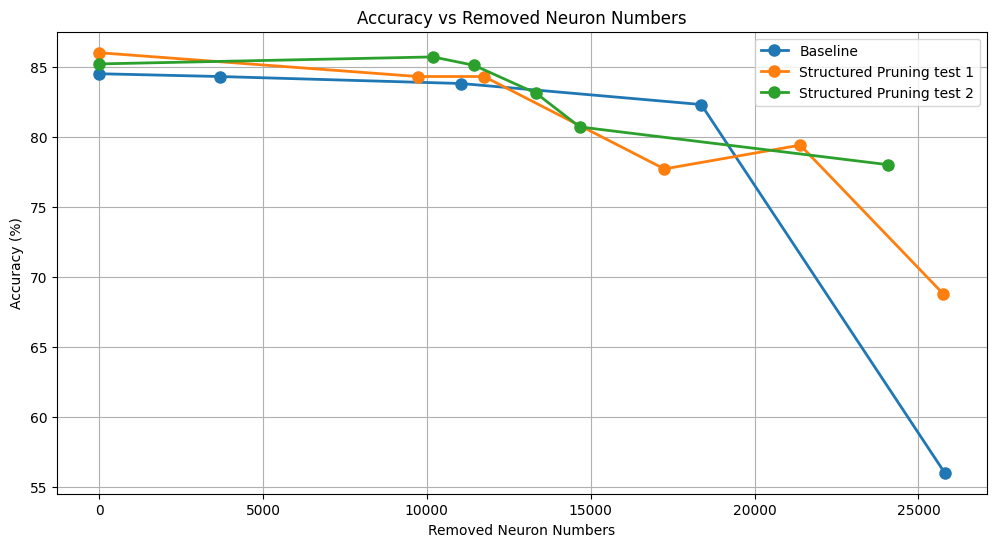

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Removed Neuron Numbers": [0, 3684, 11052, 18372, 25800, 0, 9725, 11744, 17247, 21394, 25748, 0, 10188, 11442, 13337, 14664, 24079],
    "Accuracy (%)": [84.5, 84.3, 83.8, 82.3, 56, 86, 84.3, 84.3, 77.7, 79.4, 68.8, 85.2, 85.7, 85.1, 83.1, 80.7, 78],
    "Method": ["Baseline"]*5 + ["Structured Pruning test 1"]*6 + ["Structured Pruning test 2"]*6
}

# Creating DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 6))
for method in df["Method"].unique():
    subset = df[df["Method"] == method]
    plt.plot(subset["Removed Neuron Numbers"], subset["Accuracy (%)"], marker='o', markersize=8, label=method, linewidth=2)

plt.title("Accuracy vs Removed Neuron Numbers")
plt.xlabel("Removed Neuron Numbers")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

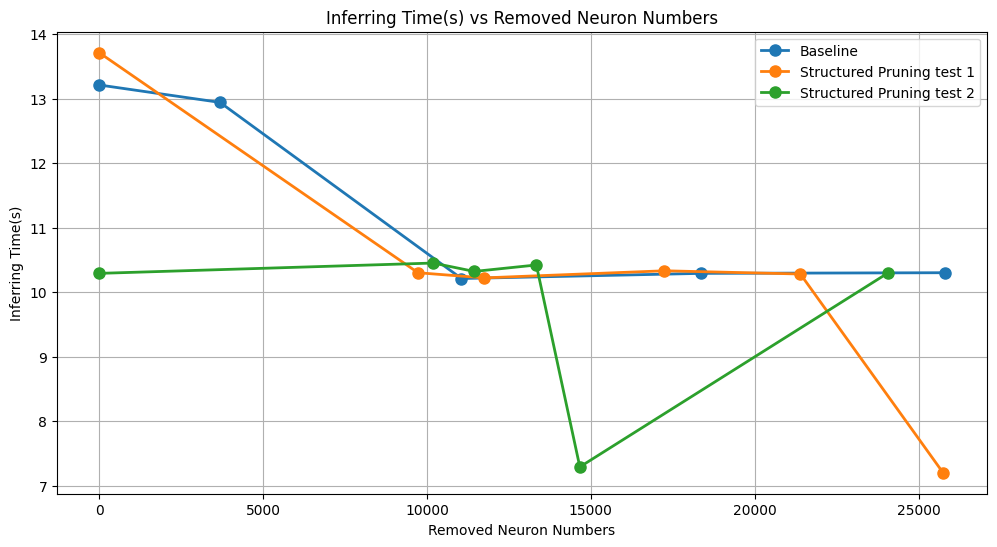

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Removed Neuron Numbers": [0, 3684, 11052, 18372, 25800, 0, 9725, 11744, 17247, 21394, 25748, 0, 10188, 11442, 13337, 14664, 24079],
    "Inferring Time(s)": [13.21, 12.94, 10.21, 10.29, 10.3, 13.71, 10.3, 10.22, 10.33, 10.28, 7.2, 10.29, 10.45, 10.32, 10.42, 7.29, 10.3],
    "Method": ["Baseline"]*5 + ["Structured Pruning test 1"]*6 + ["Structured Pruning test 2"]*6
}

# Creating DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 6))
for method in df["Method"].unique():
    subset = df[df["Method"] == method]
    plt.plot(subset["Removed Neuron Numbers"], subset["Inferring Time(s)"], marker='o', markersize=8, label=method, linewidth=2)

plt.title("Inferring Time(s) vs Removed Neuron Numbers")
plt.xlabel("Removed Neuron Numbers")
plt.ylabel("Inferring Time(s)")
plt.legend()
plt.grid(True)
plt.show()